# TICA

For users already familiar with the TICA interface: The corresponding [API docs](../api/generated/sktime.decomposition.TICA.rst#sktime.decomposition.TICA).

TICA <cite data-cite="molgedey1994separation">(Molgedey, 1994)</cite> is short for Time-lagged Independent Component Analysis and is a linear transformation method that can be used for dimensionality reduction. It was introduced for molecular dynamics in <cite data-cite="perez2013identification">(Pérez-Hernández, 2013)</cite> and as a method in the pipeline of Markov model construction in <cite data-cite="perez2013identification">(Pérez-Hernández, 2013)</cite> and <cite data-cite="schwantes2013improvements">(Schwantes, 2013)</cite>.

When the input data is the result of a Markov process, TICA finds in fact an approximation to the eigenfunctions and eigenvalues of the underlying Markov operator <cite data-cite="perez2013identification">(Pérez-Hernández, 2013)</cite>.

To that end, it maps the data to the "slow" processes, i.e., it finds the coordinates of maximal autocorrelation at a given lag time $\tau$.

Given a sequence of multivariate data $X_t$, it computes the mean-free covariance and time-lagged covariance matrix

\begin{align*}
C_0 &=      (X_t - \mu)^T \mathrm{diag}(w) (X_t - \mu), \\
C_{\tau} &= (X_t - \mu)^T \mathrm{diag}(w) (X_t + \tau - \mu),
\end{align*}

where $w$ is a vector of weights for each time step. By default, these weights
are all equal to one, but different weights are possible, like the re-weighting
to equilibrium described in <cite data-cite="wu2016variational">(Wu, 2016)</cite>. Subsequently, the eigenvalue problem

$$ C_{\tau} r_i = C_0 \lambda_i r_i $$

is solved,where $r_i$ are the independent components and $\lambda_i$ are their respective normalized time-autocorrelations. The eigenvalues are related to the relaxation timescale by

$$ t_i = -\frac{\tau}{\ln |\lambda_i|}. $$

When used as a dimension reduction method, the input data is projected
onto the dominant independent components.

In [1]:
import matplotlib.pyplot as plt  # plotting
import numpy as np
import sktime
from sklearn.decomposition import PCA  # scikit-learn PCA implementation

In [2]:
rnd = np.random.RandomState(seed=17)  # use a random state with a fixed seed for reproducibility

## Comparison vs. PCA

To demonstrate TICA compared to Principle Component Analysis (PCA), we consider the following example setup:

We generate a synthetic trajectory of observations of states $S = \{0, 1\}$ which is generated from a Markov state model (see [here](../index_msm.rst) for documentation on Markov state models). The only important thing for now is that it contains conditional probability to go from one state to another, i.e., given a transition matrix
$$
P = \begin{pmatrix} 0.97 & 0.03 \\ 0.03 & 0.97 \end{pmatrix}
$$
we have a probability $P_{11} = 97\%$ to stay in state "0" and a $P_{12} = 3\%$ to transition from state "0" to state "1" and vice versa. 

In [3]:
# creation of a Markov state model instance given a transition matrix
msm = sktime.markov.msm.MarkovStateModel(
    transition_matrix=[[0.97, 0.03], [0.03, 0.97]]
)

We simulate a discrete trajectory (dtraj) containing 1000 given the Markov state model.

In [4]:
dtraj = msm.simulate(n_steps=1000, seed=13)

Visualization of the time series:

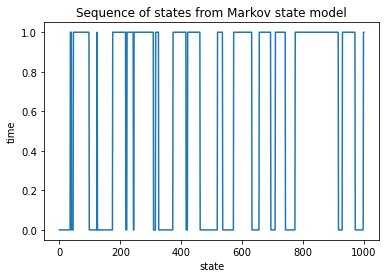

In [5]:
plt.plot(dtraj)
plt.xlabel('state')
plt.ylabel('time')
plt.title('Sequence of states from Markov state model');

Now given this sequence of states we can observe that it stays in one state for most of the time, transitions to the other state and again, stays there for a longer period of time. To demonstrate the potential advantage of TICA over PCA we map the state sequence into $\mathbb{R}^2$ by using two multivariate normal distributions with the same covariance matrix but shifted means:

In [6]:
ftraj = np.empty((len(dtraj), 2))  # allocate space for the 2-dimensional trajectory

state_0_indices = np.where(dtraj == 0)[0]  # indices where the state is 0
state_1_indices = np.where(dtraj == 1)[0]  # indices where the state is 1

cov =  [[5.7, 5.65], [5.65, 5.7]]  # the covariance matrix

# fill allocated space with samples
ftraj[state_0_indices] = rnd.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=len(state_0_indices))
ftraj[state_1_indices] = rnd.multivariate_normal(mean=[0.0, 5.0], cov=cov, size=len(state_1_indices))

Visualizing the mapped trajectory shows two parallel and elongated ellipsoid-shaped distributions. Temporally, a relatively long time is spent in either of these distributions before jumping to the other.

This can be observed in the right-hand plot: The data is supersampled (each consecutive point-pair in the time series is linearly interpolated with 50 interpolation points) so that transition jumps become visible; these transitions are significantly lower intensity than the ellipsoids. If jumps were frequent, the in-between region would be much brighter.

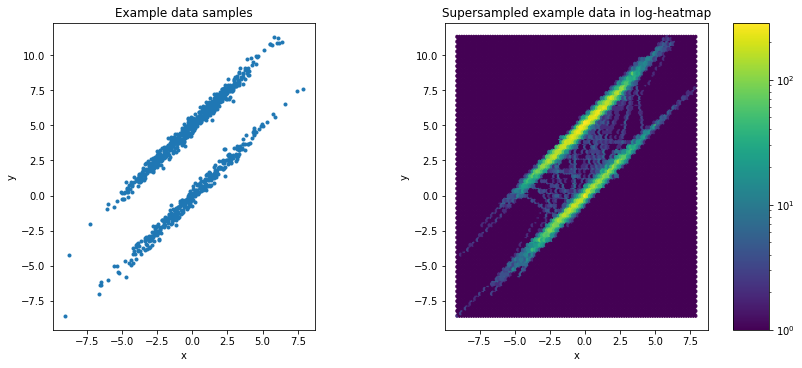

In [7]:
f, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
ax1, ax2 = axes.flat

# scatter plot of samples
ax1.scatter(*(ftraj.T), marker='.')
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Example data samples')

# interpolate ftraj so that 50 times more steps are made and transitions become visible
# in heatmap representation
n_interp = 50
ftraj_interp = np.empty((len(dtraj)*n_interp, 2))
ftraj_interp[:, 0] = np.interp(np.arange(len(dtraj), step=1./n_interp), np.arange(len(dtraj)), ftraj[:, 0])
ftraj_interp[:, 1] = np.interp(np.arange(len(dtraj), step=1./n_interp), np.arange(len(dtraj)), ftraj[:, 1])

# heatmap
hb = ax2.hexbin(ftraj_interp[:, 0], ftraj_interp[:, 1], bins='log')
ax2.set_aspect('equal')
f.colorbar(hb, ax=axes.flat)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Supersampled example data in log-heatmap');

If we project back into one dimension with PCA, the result contains basically no signal: PCA finds the axis that maximizes variance, which is along long axis of the ellipsoids and completely ignores temporal information.

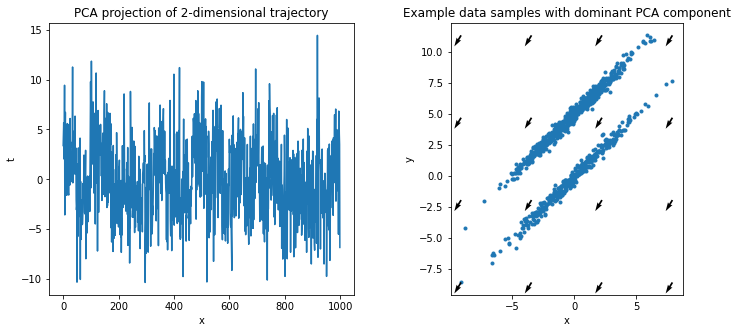

In [8]:
pca = PCA(n_components=1).fit(ftraj)  # fit the 2-dimensional data

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
projection = pca.transform(ftraj)
ax1.plot(projection)
ax1.set_title('PCA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = pca.components_[0]  # dominant pca component

ax2.scatter(*(ftraj.T), marker='.')
x, y = np.meshgrid(
    np.linspace(np.min(ftraj[:, 0]), np.max(ftraj[:, 0]), 4),
    np.linspace(np.min(ftraj[:, 1]), np.max(ftraj[:, 1]), 4)
)
plt.quiver(x,y,dxy[0],dxy[1])

ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant PCA component');

On the other hand, projecting with TICA takes temporal information into account and finds the dominant slow direction, i.e., the rare transition between the two distributions.

We create a TICA estimator, parameterized by the `lagtime`, which is the time shift $\tau$ for which autocorrelations are taken into account, and `dim`, which is the dimension. Here, the dimension can either be an `int` , a `float`, or `None` - each having significant influence on how the projection dimension is determined:

- in case `dim` is `None`, all available ranks are kept;
- in case `dim` is an integer (like in this case), it must be positive and fixes the projection dimension to the given value;
- in case `dim` is a floating point value (e.g., `TICA(..., dim=0.7)`), it must be `0 < dim <= 1`. Then, it selects the number of dimensions such that the amount of kinetic variance that needs to be explained is greater than the percentage specified by dim.

In [9]:
tica = sktime.decomposition.TICA(
    lagtime=1,  # time shift is one step
    dim=1  # fix projection dimension explicitly
)

Now the [tica model](../api/generated/sktime.decomposition.TICAModel.rst#sktime.decomposition.TICAModel) can be estimated.

**Note**: This assumes that the data comes from an equilibirum distribution. Applying the method as-is to short off-equilibrium data produces heavily biased estimates. See [Koopman reweighting](#Koopman-reweighting) (or the corresponding [API docs](../api/generated/sktime.covariance.KoopmanEstimator.rst#sktime.covariance.KoopmanEstimator)) for a reweighting technique that extends TICA to non-equilibrium data.

In [10]:
tica_model = tica.fit(ftraj).fetch_model()  # fit and fetch model

We repeat the visualization of above and plot the projected data as well as the dominant slow direction, maximizing autocorrelation (instead of variance, cf PCA).

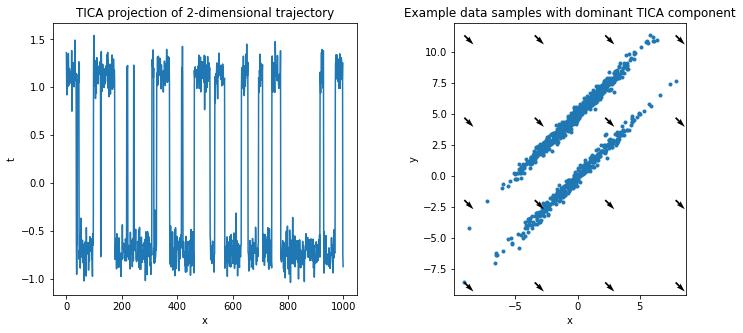

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(tica_model.transform(ftraj))
ax1.set_title('TICA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = tica_model.eigenvectors[:, 0]  # dominant tica component

ax2.scatter(*(ftraj.T), marker='.')
x, y = np.meshgrid(
    np.linspace(np.min(ftraj[:, 0]), np.max(ftraj[:, 0]), 4),
    np.linspace(np.min(ftraj[:, 1]), np.max(ftraj[:, 1]), 4)
)
plt.quiver(x, y, dxy[0], dxy[1])

ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant TICA component');

The implied timescales of the tica model can be accessed as follows:

In [12]:
tica_model.timescales(lagtime=1)

array([11.80483662,  0.28059594])

In principle, one should expect as many timescales as
input coordinates were available. However, less eigenvalues will be returned if the TICA matrices
were not full rank or `dim` contained a floating point percentage, i.e., was interpreted as
variance cutoff.

Furthermore, there is a function that yields an instantaneous correlation matrix between mean-free input features and TICs (i.e., the axes that are projected onto).

Denoting the input features as $X_i$ and the TICs as $\theta_j$, the instantaneous, linear
correlation between them can be written as

$$  \mathbf{Corr}(X_i - \mu_i, \mathbf{\theta}_j) = \frac{1}{\sigma_{X_i - \mu_i}}\sum_l \sigma_{(X_i - \mu_i)(X_l - \mu_l)} \mathbf{U}_{li}. $$

The matrix $\mathbf{U}$ is the matrix containing the eigenvectors of the TICA generalized eigenvalue problem as column vectors, i.e., there is a row for each feature and a column for each TIC.

In [13]:
tica_model.feature_tic_correlation

array([[ 0.00652733],
       [-0.65120949]])

## Eigenvector scaling

The TICA estimator possesses a scaling parameter which can be used to introduce further properties to the projection. It can take the following values:

`None`: No scaling.

In [14]:
tica.scaling = None
tica_model = tica.fit(ftraj).fetch_model()

`"kinetic_map"` (default): Eigenvectors will be scaled by eigenvalues. As a result, Euclidean distances in the transformed data approximate kinetic distances <cite data-cite="noe2015kinetic">(Noé, 2015)</cite>. This is a good choice when the data is further processed by clustering.

In [15]:
tica.scaling = "kinetic_map"  # default
tica_model_kinetic_map = tica.fit(ftraj).fetch_model()

`"commute_map"`: Eigenvector i will be scaled by $\sqrt{\mathrm{timescale}_i / 2}$. As a result, Euclidean distances in the transformed data will approximate commute distances <cite data-cite="noe2016commute">(Noé, 2016)</cite>.

In [16]:
tica.scaling = "commute_map"
tica_model_commute_map = tica.fit(ftraj).fetch_model()

Visualizing the projections:

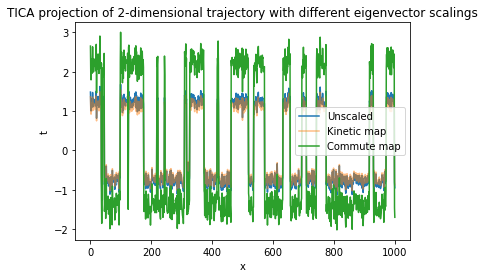

In [17]:
f, ax1 = plt.subplots(1, 1)
ax1.plot(tica_model.transform(ftraj), label="Unscaled")
ax1.plot(tica_model_kinetic_map.transform(ftraj), label="Kinetic map", alpha=.5)
ax1.plot(tica_model_commute_map.transform(ftraj), label="Commute map")
ax1.set_title('TICA projection of 2-dimensional trajectory with different eigenvector scalings')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.legend();

## Koopman reweighting

If the data that is used for estimation (for the most part) is not in equilibrium, the estimate can become heavily biased. Koopman reweighting <cite data-cite="wu2016variational">(Wu, 2016)</cite> assigns weights to each frame of the time series so that also off-equilibrium data can be used. In scikit-time, a [Koopman estimator](../api/generated/sktime.covariance.KoopmanEstimator.rst#sktime.covariance.KoopmanEstimator)) is implemented, which learns appropriate weights from data. The corresponding [Koopman model](../api/generated/sktime.covariance.KoopmanModel.rst#sktime.covariance.KoopmanModel) can be used as an argument in TICA's `fit`. 

This reweighting technique becomes necessary as soon as the available data is not a single long trajectory which equilibrates and then is in an equilibrium state for the rest of the time but rather if many short and at least initially off-equilibrium trajectories are used. 

In [17]:
tica = sktime.decomposition.TICA(lagtime=1, dim=1)

Learning the weights

In [18]:
koopman_estimator = sktime.covariance.KoopmanEstimator(lagtime=tica.lagtime)
reweighting_model = koopman_estimator.fit(ftraj).fetch_model()

...and fitting TICA using said weights.

In [19]:
tica_model_reweighted = tica.fit(ftraj, weights=reweighting_model).fetch_model()

Again the results can be visualized.

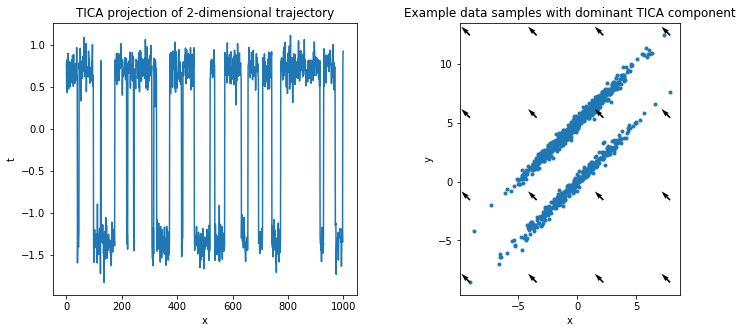

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(tica_model.transform(ftraj))
ax1.set_title('TICA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = tica_model.eigenvectors[:, 0]  # dominant tica component

ax2.scatter(*(ftraj.T), marker='.')
x, y = np.meshgrid(
    np.linspace(np.min(ftraj[:, 0]), np.max(ftraj[:, 0]), 4),
    np.linspace(np.min(ftraj[:, 1]), np.max(ftraj[:, 1]), 4)
)
plt.quiver(x, y, dxy[0], dxy[1])

ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant TICA component');

## Performance, numerical stability, and memory consumption

The implementation of TICA its generalization [VAMP](vamp.ipynb) are based on estimating covariance matrices using the [covariance estimator](../api/generated/sktime.covariance.Covariance.rst#sktime.covariance.Covariance). This estimator makes use of an online algorithm proposed in <cite data-cite="chan1982updating">(Chan, 1982)</cite> so that not the entire data has to be kept in memory. 

In particular, this means that TICA not only has a [fit()](../api/generated/sktime.decomposition.TICA.rst#sktime.decomposition.TICA.fit), but also a [partial_fit()](../api/generated/sktime.decomposition.TICA.rst#sktime.decomposition.TICA.partial_fit).

In [18]:
tica = sktime.decomposition.TICA(lagtime=1)  # creating an estimator

Since the toy data easily fits into memory, loading data from, e.g., a database or network is simulated with the [timeshifted_split()](../api/generated/sktime.data.timeshifted_split.rst#sktime.data.timeshifted_split) utility function. It splits the data into timeshifted blocks $X_t$ and $X_{t+\tau}$.

These blocks are not trajectory-overlapping, i.e., if two or more trajectories are provided then the blocks are always completely contained in exactly one of these.

Note how here we provide both blocks, the block $X_t$ and the block $X_{t+\tau}$ as a tuple. This is different to `fit()` where the splitting and shifting is performed internally; in which case it suffices to provide the whole dataset as argument.

In [20]:
for X, Y in sktime.data.timeshifted_split(ftraj, lagtime=1, chunksize=100):
    tica.partial_fit((X, Y))

Furthermore, the online algorithm of <cite data-cite="chan1982updating">(Chan, 1982)</cite> uses a tree-like moment storage with copies of intermediate covariance and mean estimates. During the learning procedure, these moment storages are combined so that the tree never exceeds a certain depth. This depth can be set by the `ncov` parameter:

In [21]:
tica = sktime.decomposition.TICA(lagtime=1, ncov=50)
for X, Y in sktime.data.timeshifted_split(ftraj, lagtime=1, chunksize=10):
    tica.partial_fit((X, Y))

Another factor to consider is numerical stability. While memory consumption can increase with larger `ncov`, the stability generally improves.